In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from joblib import load
from utils import setup_env, load_config, read_text_file
import os

#config = load_config("config.yaml")
setup_env("config.yaml")

# Get Data

In [3]:
spec_dir = config['directories'].get('spectral', 'data/spectral_dir')
flux = load(os.path.join(spec_dir, "flux.joblib"))
labels_dir = config['directories'].get('labels', 'data/label_dir/')
model_dir = config['directories'].get('models', 'data/model_dir/')
output_dir = config['directories'].get('output', 'output/')
labels = pd.read_csv(os.path.join(labels_dir, "labels.csv"))
param_names = read_text_file(os.path.join(labels_dir, 'label_names.txt'))
feh = labels['fe_h'].to_numpy()


/var/folders/0r/_b7rbmxn5839rf9g7yqn3v5w0000gn/T/ipykernel_5487/411101247.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar


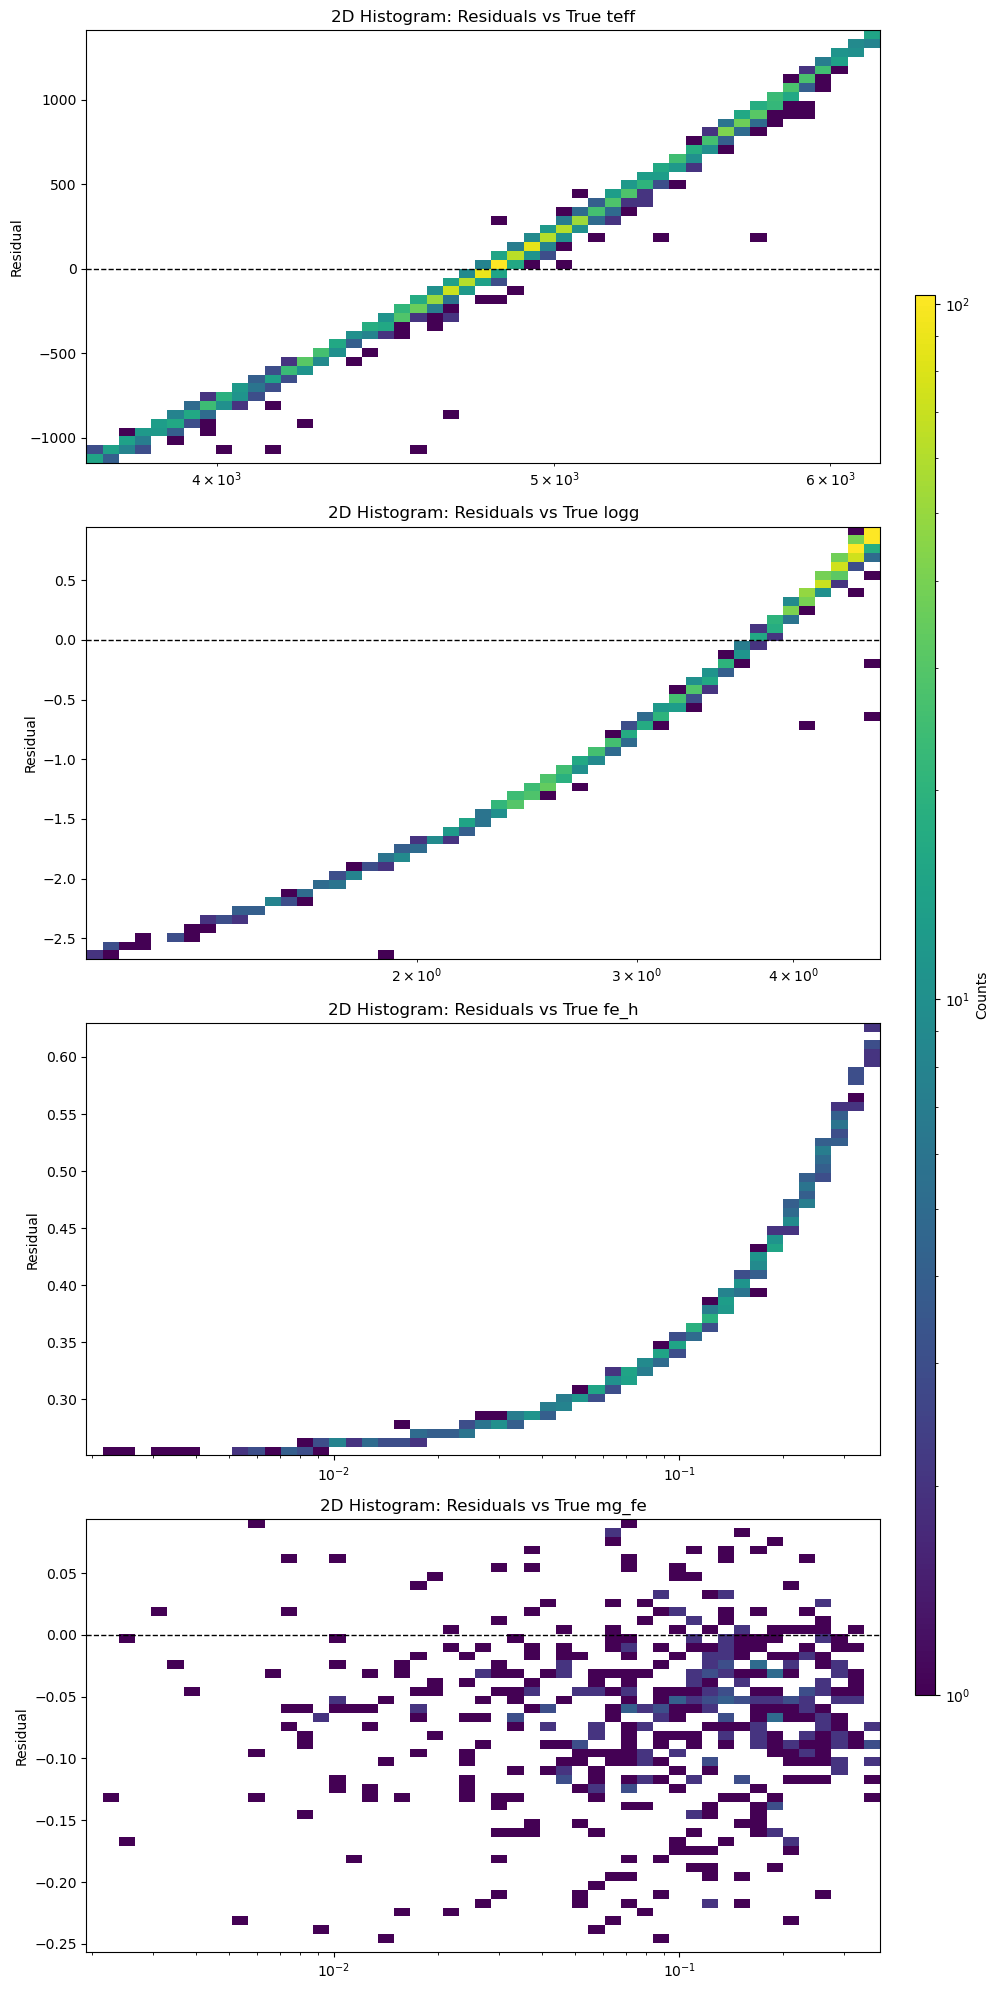

In [4]:
from matplotlib.colors import LogNorm

norm = LogNorm(vmin=1)  # Avoid log(0)

fig, axs = plt.subplots(len(param_names), 1, figsize=(10, 5 * len(param_names)))

if len(param_names) == 1:
    axs = [axs]  # Ensure iterable

for i, param in enumerate(param_names):
    residuals = pd.read_csv(os.path.join(output_dir, f"residuals/{param}_nn.csv"))

    # Identify columns
    true_col = next((col for col in ['Actual', 'True', 'true', '[Fe/H]'] if col in residuals.columns), None)
    res_col = next((col for col in ['Residuals', 'residual', 'Residual'] if col in residuals.columns), None)

    if true_col is None or res_col is None:
        axs[i].text(0.5, 0.5, "Columns not found", ha='center')
        continue

    # Clean data
    x = residuals[true_col].values
    y = residuals[res_col].values
    mask = np.isfinite(x) & np.isfinite(y) & (x > 0)
    x = x[mask]
    y = y[mask]

    # Define bins
    min_x, max_x = np.percentile(x, [1, 99])
    bins_x = np.logspace(np.log10(min_x), np.log10(max_x), 50)
    bins_y = np.linspace(np.percentile(y, 1), np.percentile(y, 99), 50)

    # Plot histogram
    h = axs[i].hist2d(x, y, bins=[bins_x, bins_y], norm=norm, cmap='viridis')
    axs[i].set_xscale('log')
    axs[i].axhline(0, color='black', linestyle='--', linewidth=1)
    axs[i].set_title(f'2D Histogram: Residuals vs True {param}')
    axs[i].set_ylabel('Residual')

# Shared colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(h[3], cax=cbar_ax, label='Counts')

plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar
plt.show()


In [ ]:
from joblib import dump
dummy_flux = np.random.rand(10, flux.shape[1])
dump(dummy_flux, os.path.join(spec_dir, "dummy_flux.joblib"))

['data/spectral_dir/dummy_flux.joblib']